In [1]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyreadstat

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
datafile = "P15644_20220301.sav"
#datafile = "P15644_ICL_20210824.sav"

df, meta = pyreadstat.read_sav(datafile, apply_value_formats=False)
df_copy = pyreadstat.set_value_labels(df, meta)
#print(meta.column_names_to_labels)
#print(meta.variable_value_labels)
df.columns

Index(['panelid_2', 'Panel_PSU', 'Panel_Strata', 'Jun21_WeightBoost',
       'Jun21_IntDate', 'Jun21_IntMode', 'ff_disact', 'Cur_GOR',
       'cur_urbrurew', 'cur_urbrurs', 'Cur_Sex', 'Cur_RClassGp', 'Cur_AgeCat',
       'Cur_HEdQual', 'Cur_RelStat5', 'Cur_HHSize5', 'Cur_HHChild',
       'Cur_HHType', 'Cur_SubjInc', 'Cur_HHIncome4_21',
       'Cur_HHIncome4_21_Imputed', 'Cur_HHIncomeEquiv4_21',
       'Cur_HHIncomeEquiv4_21_Imputed', 'Cur_IdentClass', 'Cur_PartyID5',
       'Cur_Ethnic6', 'Cur_IntUse3', 'Tenure', 'MortCost', 'RentCost',
       'CvBedRoom', 'HomeProb01', 'HomeProb02', 'HomeProb03', 'HomeProb04',
       'HomeProb05', 'HomeProb06', 'HomeProb07', 'HomeProb08', 'HomeProb09',
       'HomeProb10', 'HomeProb11', 'HomeProb12', 'HomeProb13', 'HomeProb14',
       'HomeProb15', 'HomeProb16', 'HomeProb17', 'HomeProb_Oth',
       'NeighQual_CrimeSafety_q', 'NeighQual_TrafficSafety_q',
       'NeighQual_FoodStores_q', 'NeighQual_AccessPubTrans_q',
       'NeighQual_AccessSocCult_q', 

In [3]:
df['HomeProbTotalDim'] = np.sum(df.iloc[:, 31:45],axis=1) # Home Problems 1-14 including 'other issues'
df['NeigProbTotalDim'] = np.sum(df.iloc[:, 49:61]>=4,axis=1) # Neighborhood quality dimensions with scores Poor or Very Poor
df['HealthDep'] = df['Health'].isin([4,5])*1
df['MortCost']  = df['MortCost'].fillna(0)
df['RentCost']  = df['RentCost'].fillna(0)
df['HousCost'] = df['MortCost'] + df['RentCost']

#df = df.loc[df['Cur_GOR'] == 7] #pick london only
print(df.shape)

(2777, 85)


In [4]:
df = df.drop(columns=['HomeProb01', 'HomeProb02', 'HomeProb03', 'HomeProb04',
       'HomeProb05', 'HomeProb06', 'HomeProb07', 'HomeProb08', 'HomeProb09',
       'HomeProb10', 'HomeProb11', 'HomeProb12', 'HomeProb13', 'HomeProb14',
       'HomeProb15', 'HomeProb16', 'HomeProb17', 'HomeProb_Oth',
       'NeighQual_CrimeSafety_q', 'NeighQual_TrafficSafety_q',
       'NeighQual_FoodStores_q', 'NeighQual_AccessPubTrans_q',
       'NeighQual_AccessSocCult_q', 'NeighQual_AccessRetail_q',
       'NeighQual_AccessRec_q', 'NeighQual_EaseWalk_q',
       'NeighQual_EaseCycle_q', 'NeighQual_OutdoorPlay_q',
       'NeighQual_QualitySchools_q', 'NeighQual_NeighbourSoc_q'])

In [5]:
df['HealthDep'] = df['Health'].isin([4,5])*1
df['MortCost']  = df['MortCost'].fillna(0)
df['RentCost']  = df['RentCost'].fillna(0)

In [8]:
# A column of name 'FoodTimePreCov_Cat' is created in DataFrame
# Categorizing FoodTimePreCov into 4 Categories
df['FoodTimePreCov_Cat'] = pd.cut(x=df['FoodTimePreCov'], bins=[0, 10, 20, 30, 120], labels=[0,1,2,3])
df['FoodTime_Cat'] = pd.cut(x=df['FoodTime'], bins=[0, 10, 20, 30, 120], labels=[0,1,2,3])

#                     labels=['<10min', '11-20min', '21-30min','>30min'])
#df['FoodTime_Cat'] = pd.cut(x=df['FoodTime'], bins=[0, 10, 20, 30, 120],
#                     labels=['<10min', '11-20min', '21-30min','>30min'])

# A column of name 'FoodTimePreCov_Cat' is created in DataFrame
# Categorizing FoodTimePreCov into 4 Categories labels=['=<15min', '16-30min', '31-45min', '46-60min', '>60min']
df['CommuteTimePreCov_Cat'] = pd.cut(x=df['CommuteTimePreCov'], bins=[0, 15, 30, 45, 60, 360],
                     labels=[0,1,2,3,4])
df['CommuteTime_Cat'] = pd.cut(x=df['CommuteTime'], bins=[0, 15, 30, 45, 60, 360],
                     labels=[0,1,2,3,4])

#df['CommuteTime_Cat'] = pd.cut(x=df['CommuteTime'], bins=[0, 15, 30, 45, 60, 360],
#                     labels=['<15min', '16-30min', '31-45min', '46-60min', '>60min'])


In [9]:
df.columns

Index(['panelid_2', 'Panel_PSU', 'Panel_Strata', 'Jun21_WeightBoost',
       'Jun21_IntDate', 'Jun21_IntMode', 'ff_disact', 'Cur_GOR',
       'cur_urbrurew', 'cur_urbrurs', 'Cur_Sex', 'Cur_RClassGp', 'Cur_AgeCat',
       'Cur_HEdQual', 'Cur_RelStat5', 'Cur_HHSize5', 'Cur_HHChild',
       'Cur_HHType', 'Cur_SubjInc', 'Cur_HHIncome4_21',
       'Cur_HHIncome4_21_Imputed', 'Cur_HHIncomeEquiv4_21',
       'Cur_HHIncomeEquiv4_21_Imputed', 'Cur_IdentClass', 'Cur_PartyID5',
       'Cur_Ethnic6', 'Cur_IntUse3', 'Tenure', 'MortCost', 'RentCost',
       'CvBedRoom', 'MovHom', 'EconActPreCov1', 'EconActPreCov2',
       'EconActPreCov3', 'EconActPreCov4', 'EconActPreCov5', 'WorkTimePreCov',
       'WFHPreCov', 'CommuteModePreCov', 'CommuteTimePreCov',
       'FoodShopModePreCov', 'FoodTimePreCov', 'EconAct', 'WorkTime', 'WFH',
       'CommuteMode', 'CommuteTime', 'FoodShopMode', 'FoodTime', 'Health',
       'HomeProbTotalDim', 'NeigProbTotalDim', 'HealthDep', 'HousCost',
       'FoodTimePreCov_Cat

In [10]:
df.to_csv('outtest.csv', index=False)

In [11]:
pwd

'd:\\HRX\\CASA\\Dissertation\\Dataset\\Dataset1'

In [13]:
df[(df['CommuteTimePreCov_Cat'] >= 2 )].shape
df[(df['FoodTimePreCov_Cat'] >= 2 )].shape
df[(df['FoodTimePreCov_Cat'] >= 1) & (df['CommuteTimePreCov_Cat'] >= 2 )].shape #？
df.loc[(df['FoodTimePreCov_Cat'] >= 1) & (df['CommuteTimePreCov_Cat'] >= 2 ) & (df['NeigProbTotalDim'] >= 1 )
      & (df['HomeProbTotalDim'] >= 1 ), 'HousCost'].describe()

df.loc[(df['FoodTimePreCov_Cat'] >= 2) & (df['CommuteTimePreCov_Cat'] >= 2 ) & (df['NeigProbTotalDim'] >= 1 )
      & (df['HomeProbTotalDim'] >= 1 ), 'Health'].describe()

df.loc[(df['FoodTimePreCov_Cat'] >= 1) & (df['CommuteTimePreCov_Cat'] >= 2 ) & (df['NeigProbTotalDim'] >= 1 )
      & (df['HomeProbTotalDim'] >= 1 ), 'Cur_HHIncome4_21_Imputed'].describe() #Cur_HHIncome4_21_Imputed是什么？
#df['Cur_HHIncome4_21_Imputed'].describe()

count    106.000000
mean       2.509434
std        1.097576
min        1.000000
25%        1.250000
50%        3.000000
75%        3.000000
max        4.000000
Name: Cur_HHIncome4_21_Imputed, dtype: float64

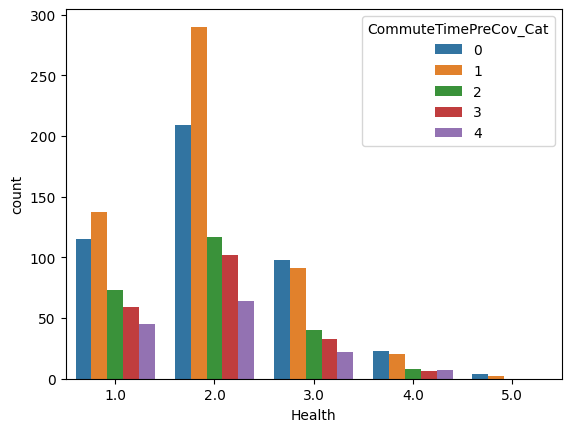

In [15]:
#ax = sns.countplot(x="Health", hue="CommuteTimePreCov_Cat", data=df)
ax = sns.countplot(x="Cur_HHIncome4_21_Imputed", hue="CommuteTimePreCov_Cat", data=df)

In [250]:
df.groupby("FoodTimePreCov_Cat")["HealthDep"].mean()
#df.groupby("Cur_AgeCat")["Health"].mean()
df.groupby("CommuteTimePreCov_Cat")["HealthDep"].mean()
df.groupby("CommuteModePreCov")["Health"].mean()

CommuteModePreCov
1.0     1.933962
2.0     1.775000
3.0     2.060000
4.0     3.000000
5.0     2.000000
6.0     2.000000
7.0     2.000000
8.0     1.657895
9.0     2.189189
11.0    2.000000
Name: Health, dtype: float64

In [158]:
# defining the dependent and independent variables
df_ = df.dropna(subset=['Cur_AgeCat', 'Cur_Sex','Cur_SubjInc', 'Cur_HEdQual','Health'])

# building the model and fitting the data
log_reg = sm.OLS(df_[['Health']], df_[['Cur_AgeCat','Cur_Sex','Cur_SubjInc', 'Cur_HEdQual']]).fit()

In [159]:
print(log_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Health   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.861
Method:                 Least Squares   F-statistic:                              4278.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):                        0.00
Time:                        12:07:35   Log-Likelihood:                         -3570.6
No. Observations:                2765   AIC:                                      7149.
Df Residuals:                    2761   BIC:                                      7173.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [39]:
df['MortCost'].describe()

count      425.000000
mean      1127.952941
std       1052.700231
min         70.000000
25%        450.000000
50%        800.000000
75%       1500.000000
max      10000.000000
Name: MortCost, dtype: float64

In [46]:
print(df.shape)
df['Tenure'].count()

(668, 88)


666

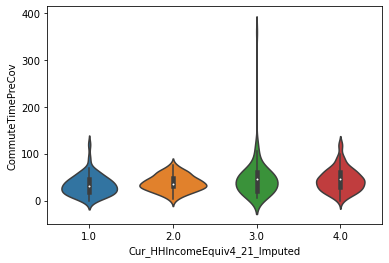

In [132]:
#ax = sns.violinplot(x="Cur_HHIncomeEquiv4_21_Imputed", y="RentCost", data=df)
#ax = sns.violinplot(x="Cur_HHIncomeEquiv4_21_Imputed", y="HomeProbTotalDim", data=df)
ax = sns.violinplot(x="Cur_HHIncomeEquiv4_21_Imputed", y="CommuteTimePreCov", data=df)

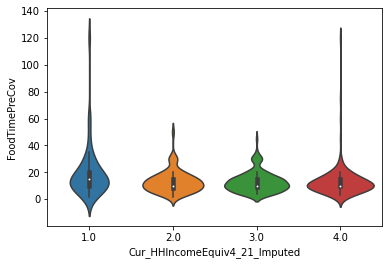

In [131]:
ax = sns.violinplot(x="Cur_HHIncomeEquiv4_21_Imputed", y="FoodTimePreCov", data=df)

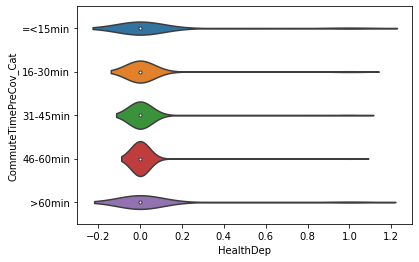

In [37]:
ax = sns.violinplot(y="CommuteTimePreCov_Cat", x="HealthDep", data=df)


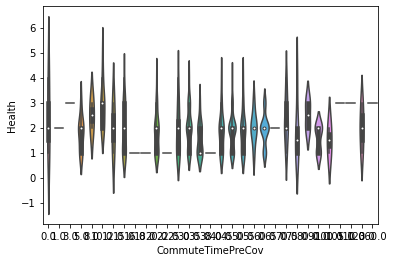

In [35]:
ax = sns.violinplot(x="CommuteTimePreCov", y="Health", data=df)

In [231]:
df['SubjInc'] = df['SubjInc'].fillna(-1)
df['SubjInc'] = df['SubjInc'].astype(int).astype('category')
df['Tenure'] = df['Tenure'].fillna(-1)

df['CommuteMode'] = df['CommuteMode'].fillna(-1)
df['CommuteModePreCov'] = df['CommuteModePreCov'].fillna(-1)
df['FoodShopMode'] = df['FoodShopMode'].fillna(-1)
df['FoodShopModePreCov'] = df['FoodShopModePreCov'].fillna(-1)

df['CommuteTime'] = df['CommuteTime'].fillna(0)
df['FoodTime'] = df['FoodTime'].fillna(0)
df['CommuteTimePreCov'] = df['CommuteTimePreCov'].fillna(0)
df['FoodTimePreCov'] = df['FoodTimePreCov'].fillna(0)

df['MortCost']  = df['MortCost'].fillna(0)
df['RentCost']  = df['RentCost'].fillna(0)


df[['NeighQual_CrimeSafety_q', 'NeighQual_TrafficSafety_q', 'NeighQual_FoodStores_q',
       'NeighQual_AccessPubTrans_q', 'NeighQual_AccessSocCult_q',
       'NeighQual_AccessRetail_q', 'NeighQual_AccessRec_q',
       'NeighQual_EaseWalk_q', 'NeighQual_EaseCycle_q',
       'NeighQual_OutdoorPlay_q', 'NeighQual_QualitySchools_q',
       'NeighQual_NeighbourSoc_q']].fillna(-1, inplace=True)


/Users/esrasuel/opt/anaconda3/envs/maps/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [232]:
data = df[['Tenure', 'MortCost', 'RentCost',
       'CvBedRoom', 'CommuteMode', 'CommuteTime',
       'FoodShopMode', 'FoodTime']]

data = df[['Tenure', 'MortCost', 'RentCost', 'CommuteTime', 'FoodTime']]

In [233]:
data[data['FoodTime'].isna()]


,Tenure,MortCost,RentCost,CommuteTime,FoodTime


In [235]:
df['Health'] = df['Health'].fillna(-1).astype(int).astype('category')
true_label_names = df[['Health']].values.ravel()

<AxesSubplot:>

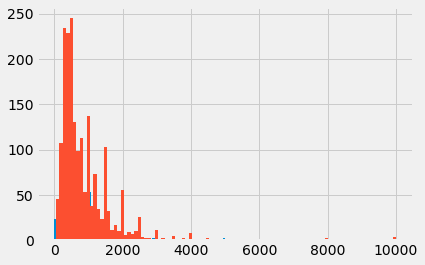

In [236]:
data.loc[data["RentCost"]>0, "RentCost"].hist(bins=100)
data.loc[data["MortCost"]>0, "MortCost"].hist(bins=100)

In [237]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(true_label_names)
true_labels

array([2, 2, 3, ..., 2, 3, 0])

In [238]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [239]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=10,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

In [240]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [241]:
pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=10, n_init=50,
                                         random_state=42))]))])

In [242]:
preprocessed_data = pipe["preprocessor"].transform(data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.45414007309768595

In [243]:
adjusted_rand_score(true_labels, predicted_labels)


0.013638557167221031

/Users/esrasuel/opt/anaconda3/envs/maps/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


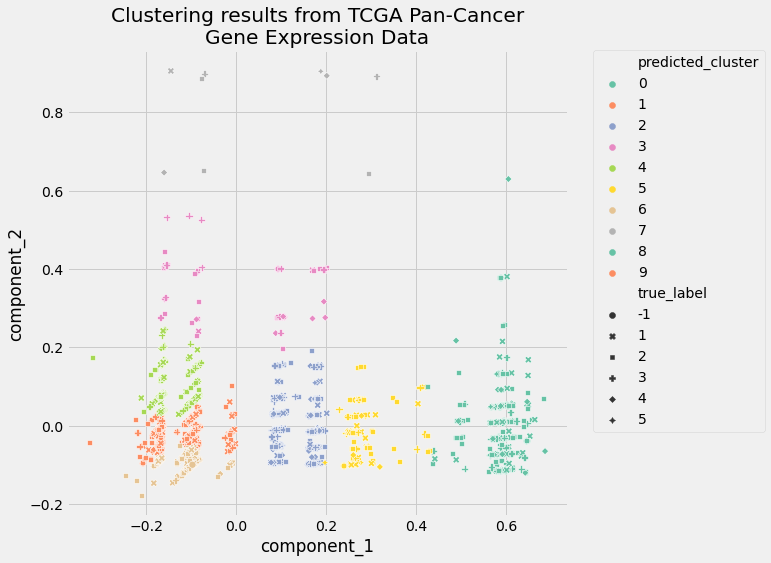

In [244]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [246]:
# Empty lists to hold evaluation metrics
silhouette_scores = []
ari_scores = []
for n in range(2, 5):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(data)

    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(data),
        pipe["clusterer"]["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
        true_labels,
        pipe["clusterer"]["kmeans"].labels_,
    )

    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

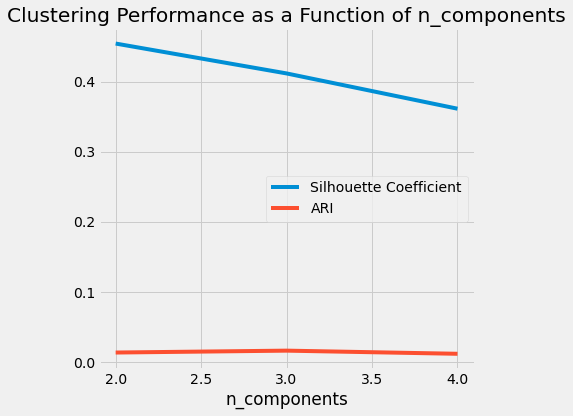

In [250]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 5),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 5), ari_scores, c="#fc4f30", label="ARI")

plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
plt.show()